# Diamanter

Jag har f√•tt i uppdrag av ledningen p√• Guldfynd att analysera ett dataset fr√•n en diamantgrossist, inneh√•llande relevanta priser och specifikationer f√∂r olika typer av diamanter. 

**Syftet** med analysen √§r att utv√§rdera potentiella investeringsm√∂jligheter f√∂r f√∂retaget, med fokus p√• att unders√∂ka f√∂ruts√§ttningarna f√∂r att inkludera diamantsmycken i v√•rt produktsortiment.

**M√•let** √§r att tydligt identifiera strategi √∂ver vilka typer av diamanter som utg√∂r de mest attraktiva investeringsalternativen, samt att kunna, genom att anv√§nda strategin, peka ut specifika exemplar i grossistens dataset som bed√∂ms vara s√§rskilt f√∂rdelaktiga att investera i just nu.

## Bakgrund

Diamanter √§r en av v√§rldens mest eftertraktade √§delstenar och anv√§nds i allt fr√•n smycken till industriverktyg. Deras v√§rde baseras inte bara p√• estetiska egenskaper, utan ocks√• p√• flera standardiserade kvalitetskriterier. F√∂r f√∂retag som √∂verv√§ger att investera i diamanter, exempelvis genom att inkludera diamantsmycken i sitt sortiment ‚Äì √§r det avg√∂rande att f√∂rst√• vilka faktorer som styr prisbilden, hur marknaden fungerar och vilka risker och m√∂jligheter som finns.

>### Fyra C:na, grunden f√∂r diamantv√§rdering:
>>**Carat** _(vikt)_: Ju h√∂gre vikt, desto mer s√§llsynt och v√§rdefull √§r diamanten. Dock stiger priset inte linj√§rt ‚Äì sm√• skillnader i carat kan ge stora prisvariationer.

>>**Cut** _(slipning)_: Slipningen avg√∂r hur ljuset reflekteras i diamanten, vilket p√•verkar dess briljans och visuell kvalitet.

>>**Color** _(f√§rg)_: I kontrast till informationen i det PDF-dokument jag tagit del av (diamonds_info), √§r de mest eftertraktade diamanterna de som √§r helt f√§rgl√∂sa. F√§rg graderas enligt den internationella GIA-skalan fr√•n D (helt f√§rgl√∂s) till Z (tydlig gul ton), d√§r D representerar den h√∂gsta f√§rgkvaliteten.

>>**Clarity** _(klarhet)_: M√•tt p√• inre och yttre defekter (inklusioner). Ju f√§rre defekter, desto h√∂gre v√§rde.

>#### Marknadsaspekter att beakta:
>>**Prisvariationer**: Tv√• diamanter med liknande carat kan skilja kraftigt i pris beroende p√• f√§rg, klarhet och slipning.

>>**Efterfr√•gem√∂nster**: Konsumenter tenderar att f√∂redra vissa specifikationer beroende p√• trender, kulturella preferenser och k√∂pkraft.

## Analys

I analysen av datasettet kommer vi att g√• igenom:  
1. Bortagning av felaktig data.  
2. √ñverblick √∂ver datasettet.  
3. M√•lgruppsspecifiering.  
4. Efterfr√•gan och f√∂retagsbild.  
5. Volatilitet.  
6. Investeringskategorier.  
7. Investeringsm√∂jligheter i det aktuella datasettet.  
8. √Öterkoppling till m√•let.

Jag kommer b√∂rja med att visa hur jag utesl√∂t felaktig data i datasettet.

#### 1. Bortagning av felaktig data

In [554]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def clean_diamond_data(df):
    total_start = df.shape[0]
    removed = {}

    # Rensar ut nullv√§rden
    before = df.shape[0]
    df = df.dropna(subset=['index', 'cut', 'color', 'clarity', 'price', 'carat', 'x', 'y', 'z', 'depth'])
    removed["Saknade v√§rden"] = before - df.shape[0]

    # Nollv√§rden i numeriska kolumner
    numeric_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
    before = df.shape[0]
    for col in numeric_cols:
        df = df[df[col] > 0]
    removed["Nollv√§rden i numeriska kolumner"] = before - df.shape[0]

    # Extrema m√•tt
    before = df.shape[0]
    df = df[(df['x'] <= 15) & (df['y'] <= 15) & (df['z'] <= 15)]
    removed["Extrema m√•tt (>15 mm)"] = before - df.shape[0]

    # Oproportionerligt djup
    before = df.shape[0]
    df = df[~((df['carat'] < 1) & (df['z'] > 10))]
    removed["Misst√§nkt djup (carat < 1 & z > 10)"] = before - df.shape[0]

    # Depth-avvikelse
    df['depth_calc'] = (df['z'] / ((df['x'] + df['y']) / 2)) * 100
    df['depth_diff'] = abs(df['depth_calc'] - df['depth'])
    before = df.shape[0]
    df = df[df['depth_diff'] <= 1]
    removed[">1% avvikelse i depth"] = before - df.shape[0]

    # Sammanst√§llning
    print("Sammanst√§llning av borttagna rader:")
    for reason, quant in removed.items():
        print(f"- {reason}: {quant} rader")

    total_borttagna = total_start - df.shape[0]
    print(f"\nTotalt borttagna rader: {total_borttagna}")
    print(f"Rader kvar: {df.shape[0]}")

    return df


df = clean_diamond_data(pd.read_csv("diamonds.csv", sep=";"))

Sammanst√§llning av borttagna rader:
- Saknade v√§rden: 74 rader
- Nollv√§rden i numeriska kolumner: 22 rader
- Extrema m√•tt (>15 mm): 3 rader
- Misst√§nkt djup (carat < 1 & z > 10): 0 rader
- >1% avvikelse i depth: 77 rader

Totalt borttagna rader: 176
Rader kvar: 53764


**Jag har utvecklat en funktion som reng√∂r datasettet genom att stegvis filtrera bort diamanter som:**  
1. Saknar n√∂dv√§ndiga v√§rden  
2. Har nollv√§rden i fysiska m√•tt (x, y, z)  
3. Uppvisar extrema dimensioner (√∂ver 15 mm)  
4. Har oproportionerligt stort djup i f√∂rh√•llande till sin vikt (carat < 1 och z > 10 mm)  
Uppvisar en avvikelse p√• mer √§n 1‚ÄØ% mellan angivet djup och det geometriskt ber√§knade djupet  

Syftet med denna funktion √§r att s√§kerst√§lla att den fortsatta analysen baseras p√• ett s√• korrekt och tillf√∂rlitligt underlag som m√∂jligt.

### 2. √ñverblick √∂ver datasettet

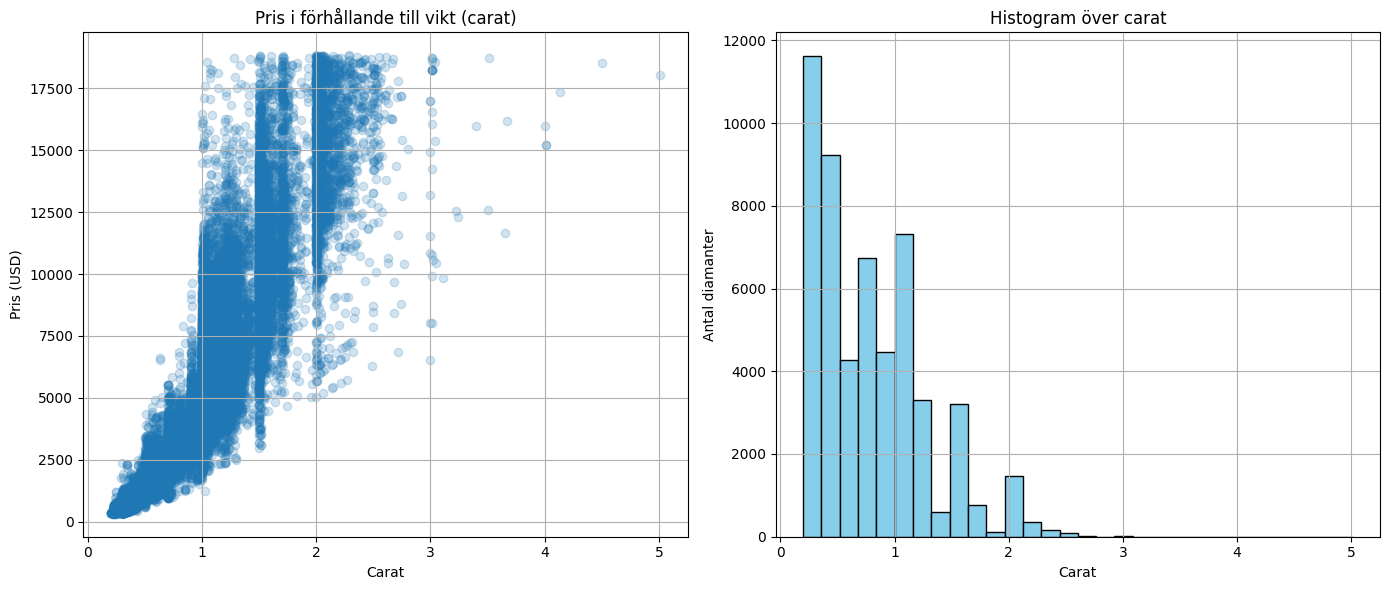

In [558]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(df['carat'], df['price'], alpha=0.2)
ax[0].set_title('Pris i f√∂rh√•llande till vikt (carat)')
ax[0].set_xlabel('Carat')
ax[0].set_ylabel('Pris (USD)')
ax[0].grid(True)

ax[1].hist(df['carat'], bins=30, color='skyblue', edgecolor='black')
ax[1].set_title('Histogram √∂ver carat')
ax[1].set_xlabel('Carat')
ax[1].set_ylabel('Antal diamanter')
ax[1].grid(True)

plt.tight_layout()
plt.show()

I de tv√• √∂versiktsdiagrammen framg√•r det att majoriteten av diamanterna v√§ger under 1 carat, och att priset generellt √∂kar i takt med caratv√§rdet.

Vi kan √§ven se att vid vissa specifika viktgr√§nser, s√•som 1.0, 1.5 och 2.0 carat, tenderar priserna att vara b√•de h√∂gre och mer utspridda j√§mf√∂rt med n√§rliggande caratniv√•er. Detta tyder p√• att dessa caratgr√§nser har ett s√§rskilt marknadsv√§rde eller efterfr√•gem√∂nster.

## 3. M√•lgruppsspecifiering

Efter en marknadsanalys framg√•r det att diamanter under 1.0 carat √§r vanligast f√∂rekommande i smyckesproduktion.

I Norden pr√§glas efterfr√•gan av mer √•terh√•llsamma preferenser, vigselringar inneh√•ller vanligtvis stenar p√• mellan 0.3 och 1.0 carat, medan andra smycken som √∂rh√§ngen, halsband och armband ofta anv√§nder √§nnu mindre diamanter.

I kontrast till detta ser vi i datan att diamanter p√• 1.0, 1.5 och 2.0 carat √§r betydligt vanligare i exempelvis den amerikanska marknaden, d√§r st√∂rre stenar ofta f√∂rekommer i vigselringar.

Diamanter √∂ver 2.5 carat √§r relativt ovanliga inom traditionell smyckesdesign och √•terfinns fr√§mst i investeringssyfte.

Mot denna bakgrund rekommenderas att vi p√• Guldfynd fokuserar p√• diamanter i spannet 0.1‚Äì1.0 carat. Detta kommer att medf√∂ra nackdelen att Guldfynd inte erbjuda extremt unika och exsklusiva diamater, tex en diamant p√• 3 karat. Men m√•lgruppen vi har i nordiska l√§nder st√§rker bilden av att 0.1-1.0 √§r det karat spanned vi b√∂r l√§gga fokus p√•.  

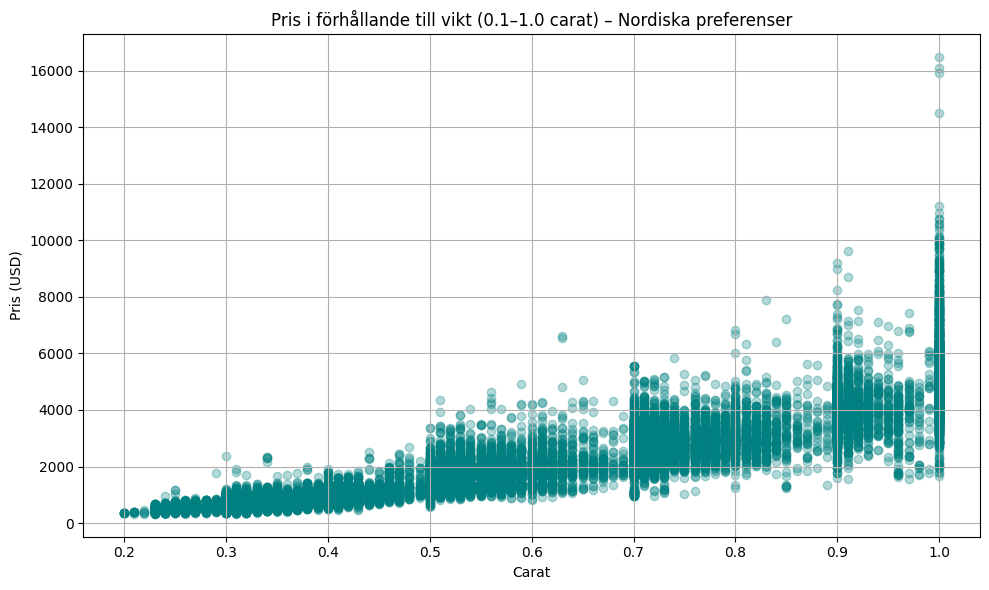

In [563]:
nordic_df = df[(df['carat'] >= 0.1) & (df['carat'] <= 1.0)]

plt.figure(figsize=(10, 6))
plt.scatter(nordic_df['carat'], nordic_df['price'], alpha=0.3, color='teal')
plt.title('Pris i f√∂rh√•llande till vikt (0.1‚Äì1.0 carat) ‚Äì Nordiska preferenser')
plt.xlabel('Carat')
plt.ylabel('Pris (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

*Detta diagram visar alla diamanter som √§r under 1 carat i datasettet.*

## 4. Efterfr√•gan och f√∂retagsbild

Diamanter med synliga inneslutningar eller missf√§rgningar uppfattas generellt som mindre exklusiva och kan p√•verka kundens upplevelse negativt. Det visuella spelar stor roll f√∂r en kund, allts√• clarity, vilket motsvarar klarheten i diamanten, color vilket √§r f√§rgen med of√§rgad som h√∂gst eftertraktad (D). Cut som motsvarar slipningen √§r d√§remot inte lika synligt f√∂r kunden eftersom det p√•verkar endast reflektionen i diamanten.   

F√∂r att uppr√§tth√•lla Guldfynds position som en kvalitetsleverant√∂r b√∂r vi undvika att inkludera stenar som upplevs som smutsiga, suddiga eller f√§rgf√∂r√§ndrade.

Jag rekommenderar d√§rf√∂r att vi enbart investerar i diamanter med h√∂g klarhet (clarity), s√• l√•g f√§rggrad som m√∂jligt samt god slipning (cut). Detta s√§kerst√§ller att v√•ra smycken h√•ller en h√∂g visuell standard och st√§rker kundens f√∂rtroende f√∂r varum√§rket.

Eftersom b√•de datam√§ngden och omv√§rldsanalysen visar att det finns ett stort utbud av diamanter inom det aktuella spannet, kr√§vs en tydlig strategi f√∂r att identifiera de alternativ d√§r f√∂retaget har m√∂jlighet att uppn√• god l√∂nsamhet.

D√§rf√∂r kommer vi nu att unders√∂ka prisvolatiliteten inom detta segment med clarity, f√§rg och cut i √•tanke, f√∂r att identifiera var de mest gynnsamma investeringsm√∂jligheterna finns.

## 5. Volatilitet

>#### Volatiliteten grupperat i color

In [647]:
nordic_df = nordic_df.copy()

# Grupperar i 0.1 carat
nordic_df['carat_bin'] = pd.cut(nordic_df['carat'], bins=np.arange(0.1, 1.05, 0.1))

# Gruppera p√• caratintervall + f√§rg, och ber√§kna variation
volatility = nordic_df.groupby(['carat_bin', 'color'], observed=False)['price'].agg(['mean', 'std', 'min', 'max'])
volatility['variation'] = volatility['std'] / volatility['mean']
volatility = volatility.dropna()
volatility_sorted = volatility.sort_values(by=['carat_bin', 'variation'], ascending=[True, False])

# Tar top 2 f√∂r varje carat_bin
top2_per_bin = volatility_sorted.groupby(level='carat_bin', observed=True).head(2)

topp2_f√§rger = f√§rg_frekvens.head(2)

print("Topp 2 vanligaste f√§rger bland mest volatila per carat-intervall:")
print(topp2_f√§rger)

Topp 2 vanligaste f√§rger bland mest volatila per carat-intervall:
color
D    8
E    3
Name: count, dtype: int64


>#### Volatiliteten grupperat i clarity

In [573]:
nordic_df = nordic_df.copy()

if 'carat_bin' not in nordic_df.columns:
    nordic_df['carat_bin'] = pd.cut(nordic_df['carat'], bins=np.arange(0.1, 1.05, 0.1))

clarity_volatility = nordic_df.groupby(['carat_bin', 'clarity'], observed=False)['price'].agg(['mean', 'std', 'min', 'max'])
clarity_volatility['variation'] = clarity_volatility['std'] / clarity_volatility['mean']
clarity_volatility = clarity_volatility.dropna()

clarity_sorted = clarity_volatility.sort_values(by=['carat_bin', 'variation'], ascending=[True, False])

top2_per_bin_clarity = clarity_sorted.groupby(level='carat_bin', observed=True).head(2)

clarity_frekvens = top2_per_bin_clarity.reset_index()['clarity'].value_counts()

topp2_clarity = clarity_frekvens.head(2)

print("Topp 2 vanligaste clarity-v√§rden bland mest volatila per carat-intervall:")
print(topp2_clarity)

Topp 2 vanligaste clarity-v√§rden bland mest volatila per carat-intervall:
clarity
IF      6
VVS1    5
Name: count, dtype: int64


>#### Volatiliteten grupperat i cut

In [576]:
nordic_df = nordic_df.copy()

if 'carat_bin' not in nordic_df.columns:
    nordic_df['carat_bin'] = pd.cut(nordic_df['carat'], bins=np.arange(0.1, 1.05, 0.1))

cut_volatility = nordic_df.groupby(['carat_bin', 'cut'], observed=False)['price'].agg(['mean', 'std', 'min', 'max'])
cut_volatility['variation'] = cut_volatility['std'] / cut_volatility['mean']
cut_volatility = cut_volatility.dropna()

cut_sorted = cut_volatility.sort_values(by=['carat_bin', 'variation'], ascending=[True, False])

top2_per_bin_cut = cut_sorted.groupby(level='carat_bin', observed=True).head(2)

cut_frekvens = top2_per_bin_cut.reset_index()['cut'].value_counts()

topp2_cut = cut_frekvens.head(2)

print("Topp 2 vanligaste cut-niv√•er bland mest volatila per carat-intervall:")
print(topp2_cut)

Topp 2 vanligaste cut-niv√•er bland mest volatila per carat-intervall:
cut
Fair     7
Ideal    4
Name: count, dtype: int64


## 6. Investeringskategorier

Baserat p√• ber√§kningarna ovan framg√•r det att diamanter med vissa specifika attribut uppvisar olika grad av prisvolatilitet.

En diamant med egenskaperna

Color: D

Clarity: IF

Cut: Fair

uppvisar den h√∂gst volatiliteten i pris.

In [580]:
filtered = nordic_df[
    (nordic_df['color'].isin(['D', 'E'])) &
    (nordic_df['clarity'].isin(['IF', 'VVS2']))
]

kombinationer = filtered.groupby(['color', 'clarity', 'cut']).size().reset_index(name='antal')
print(kombinationer)

   color clarity        cut  antal
0      D      IF       Fair      3
1      D      IF       Good      5
2      D      IF      Ideal     22
3      D      IF    Premium      5
4      D      IF  Very Good     13
5      D    VVS2       Fair      8
6      D    VVS2       Good     23
7      D    VVS2      Ideal    233
8      D    VVS2    Premium     75
9      D    VVS2  Very Good    128
10     E      IF       Good      9
11     E      IF      Ideal     67
12     E      IF    Premium     19
13     E      IF  Very Good     34
14     E    VVS2       Fair     13
15     E    VVS2       Good     43
16     E    VVS2      Ideal    446
17     E    VVS2    Premium    105
18     E    VVS2  Very Good    277


Genom att ta de tv√• h√∂gsta volatilitetsgrupperna inom color och clarity fr√•n utr√§kningen kan vi sammanst√§lla att en diamant med n√•gon av kombinationerna ovan har h√∂gre volatilitet √§n andra kombinationer i datasettet.
Detta √∂ppnar upp m√∂jligheter f√∂r oss p√• Guldfynd att g√∂ra strategiska ink√∂p till l√§gre prisniv√•er och d√§refter s√§lja med god marginal.

Samtidigt ligger color och clarity h√∂gt i sina respektive kvalitetsskalor, vilket sammanstr√•lar med bilden av Guldfynd som en leverant√∂r av exklusiva och eftertraktade smycken. Eftersom utr√§kningen av de tv√• h√∂gsta volatilitetsgrupper inom kategorin cut visar, Fair(vilket √§r den l√§gsta) och Ideal(vilket √§r den h√∂gsta) st√§mmer detta ocks√• in med omv√§rldsanalysen, d√§r den inte har samma betydelse f√∂r kunden. Deta inneb√§r att vi kan utesluta cut fr√•n att ha en betydande roll i v√•ra investeringsm√∂jligheter.

## 7. Investeringsm√∂jligheter i det aktuella datasettet

In [605]:
def cheap_diamonds_by_carat(df, group_columns, price_column="price", carat_column="carat"):
    df = df[df[carat_column] <= 1.0].copy()

    result = []
    groups = df.groupby(group_columns)

    for name, group in groups:
        group = group.copy()
        group['carat_round'] = (group[carat_column] * 10).round() / 10

        for carat_val, sub_group in group.groupby('carat_round'):
            if len(sub_group) < 10:
                continue

            median_price = sub_group[price_column].median()
            cheap = sub_group[sub_group[price_column] < median_price].copy()
            cheap["kategori"] = f"{name[0]},{name[1]},{name[2]}"
            cheap["med_price"] = median_price  # üëà L√§gg till detta
            cheap["un_med_usd"] = (median_price - cheap[price_column]).round(2)
            cheap["un_med_percent"] = ((median_price - cheap[price_column]) / median_price * 100).round(1)
            result.append(cheap)

    if result:
        return pd.concat(result, ignore_index=True)
    else:
        return pd.DataFrame()
cheap = cheap_diamonds_by_carat(filtered, ['color', 'clarity', 'cut'])

cheap = cheap.sort_values(by="un_med_usd", ascending=False)

top50 = cheap[['index','price','med_price', 'un_med_usd', 'un_med_percent', 'kategori']].head(50)
print(top50)

     index   price  med_price  un_med_usd  un_med_percent          kategori
103   1783  3049.0     4369.0      1320.0            30.2      D,VVS2,Ideal
104   2011  3103.0     4369.0      1266.0            29.0      D,VVS2,Ideal
448   1984  3093.0     3990.0       897.0            22.5      E,VVS2,Ideal
98   51833  2421.0     3282.0       861.0            26.2      D,VVS2,Ideal
449   2672  3238.0     3990.0       752.0            18.8      E,VVS2,Ideal
99   53085  2612.0     3282.0       670.0            20.4      D,VVS2,Ideal
100  53120  2617.0     3282.0       665.0            20.3      D,VVS2,Ideal
101  53247  2644.0     3282.0       638.0            19.4      D,VVS2,Ideal
407  45230  1657.0     2292.5       635.5            27.7      E,VVS2,Ideal
105   4981  3737.0     4369.0       632.0            14.5      D,VVS2,Ideal
102  53720  2720.0     3282.0       562.0            17.1      D,VVS2,Ideal
408  46070  1736.0     2292.5       556.5            24.3      E,VVS2,Ideal
106   5542  

Funktionen ovan fokuserar p√• diamanter under 1.0 carat, i linje med f√∂retagets m√•lgrupp, och grupperar d√§refter datan utifr√•n kombinationer av kvalitetskriterier. Inom varje grupp d√§r det finns mer √§n 10 diamanter j√§mf√∂rs diamanternas pris med medianpriset i samma caratintervall. De som √§r billigare √§n medianen lyfts fram som potentiellt prisv√§rda.

Resultatet sorteras sedan utifr√•n hur mycket priset avviker ned√•t i dollar fr√•n medianen, vilket g√∂r det m√∂jligt att snabbt identifiera de mest attraktiva k√∂ptillf√§llena utifr√•n f√∂retagets kravspecifikation. Vid behov kan vi sortera efter procenten j√§mf√∂rt med medianen, f√∂r att f√• en snabb √∂verblick √∂ver pontentiell rea.

Nu kommer jag visa en √∂verblick igen d√§r de top 50 b√§sta investeringsm√∂jlighetern i datasettet finns.

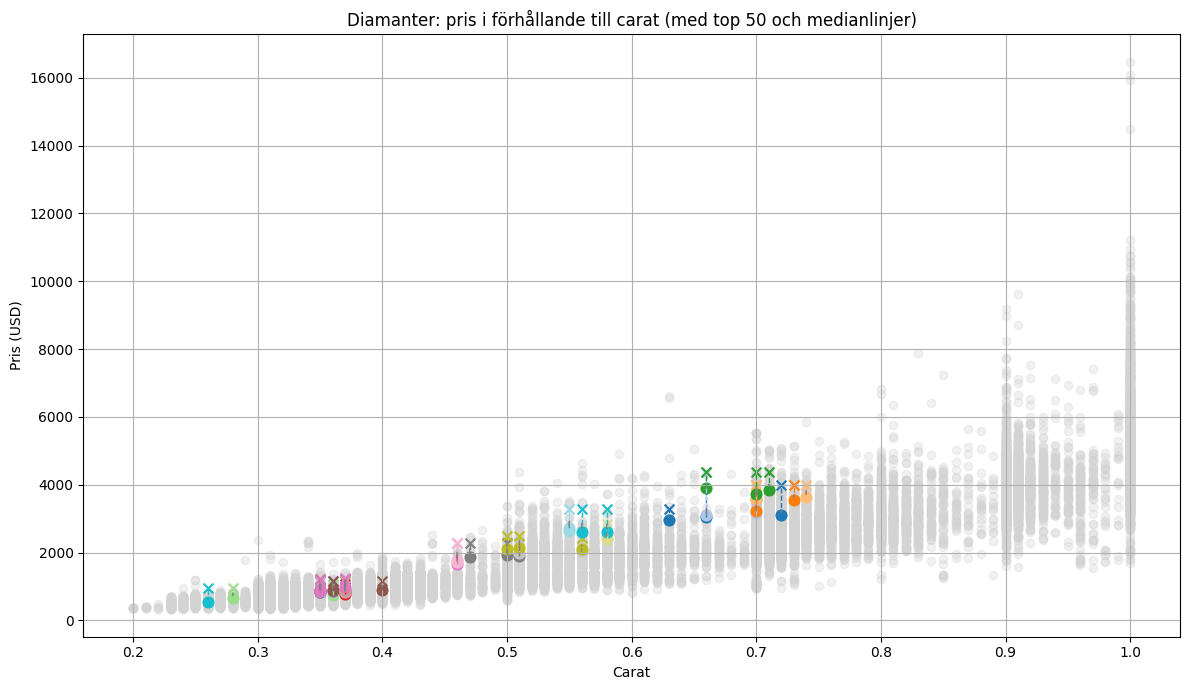

ID 51978: E,IF,Very Good ‚Äì 547.0 USD (‚àí42.6% mot median)
ID 27364: E,VVS2,Premium ‚Äì 646.0 USD (‚àí32.0% mot median)
ID 30785: E,VVS2,Very Good ‚Äì 742.0 USD (‚àí30.7% mot median)
ID 1783: D,VVS2,Ideal ‚Äì 3049.0 USD (‚àí30.2% mot median)
ID 34257: D,VVS2,Ideal ‚Äì 857.0 USD (‚àí29.2% mot median)
ID 2011: D,VVS2,Ideal ‚Äì 3103.0 USD (‚àí29.0% mot median)
ID 33925: E,VVS2,Ideal ‚Äì 844.0 USD (‚àí28.2% mot median)
ID 33926: E,VVS2,Ideal ‚Äì 844.0 USD (‚àí28.2% mot median)
ID 33659: D,VVS2,Very Good ‚Äì 835.0 USD (‚àí28.1% mot median)
ID 34022: E,VVS2,Ideal ‚Äì 849.0 USD (‚àí27.8% mot median)
ID 34021: E,VVS2,Ideal ‚Äì 849.0 USD (‚àí27.8% mot median)
ID 45230: E,VVS2,Ideal ‚Äì 1657.0 USD (‚àí27.7% mot median)
ID 32047: E,VVS2,Very Good ‚Äì 779.0 USD (‚àí27.2% mot median)
ID 34998: D,VVS2,Ideal ‚Äì 882.0 USD (‚àí27.1% mot median)
ID 51833: D,VVS2,Ideal ‚Äì 2421.0 USD (‚àí26.2% mot median)
ID 34681: E,VVS2,Ideal ‚Äì 873.0 USD (‚àí25.8% mot median)
ID 34743: E,VVS2,Ideal ‚Äì 876.0 USD (

In [634]:
# F√§rger (tab20 interpolerad till 50 f√§rger)
cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i / 50) for i in range(50)]

# V√§lj tydligt vad vi vill ha med i merge
top50_full = nordic_df[['index', 'carat', 'price']].merge(
    top50[['index', 'med_price', 'un_med_percent', 'kategori']], on='index', how='inner'
)

plt.figure(figsize=(12, 7))
plt.scatter(nordic_df['carat'], nordic_df['price'], alpha=0.3, color='lightgray', label='Alla diamanter')

# Rita linjer + prickar
for i, (_, row) in enumerate(top50_full.iterrows()):
    color = colors[i]
    carat = row['carat']
    price = row['price']
    median_price = row['med_price']
    idx = int(row['index'])

    plt.plot([carat, carat], [price, median_price], color=color, linestyle='--', linewidth=1)
    plt.scatter(carat, price, color=color, s=60)
    plt.scatter(carat, median_price, color=color, marker='x', s=50)

    plt.annotate(
        text=str(),
        xy=(carat, price),
        xytext=(carat, price + 250 + np.random.uniform(-100, 100)),
        arrowprops=dict(arrowstyle='-', color='gray'),
        fontsize=8,
        color='black',
        ha='center'
    )

plt.title('Diamanter: pris i f√∂rh√•llande till carat (med top 50 och medianlinjer)')
plt.xlabel('Carat')
plt.ylabel('Pris (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()
# Sortera top50 efter procentuell skillnad mot medianen (st√∂rst f√∂rst)
sorted_top50 = top50.sort_values(by='un_med_percent', ascending=False)

# Skriva ut listan
for _, row in sorted_top50.iterrows():
    print(f"ID {int(row['index'])}: {row['kategori']} ‚Äì {row['price']} USD (‚àí{row['un_med_percent']}% mot median)")

### Vinst i datasettet

In [637]:
top50_diamonds = top50.copy()

# (Den h√§r raden g√∂r inget, du kan ta bort den)
# top50_diamonds = top50_diamonds.rename(columns={"un_med_usd": "un_med_usd"})

top50_diamonds['med_price'] = top50_diamonds['price'] + top50_diamonds['un_med_usd']
top50_diamonds['med_price_10pct'] = top50_diamonds['med_price'] * 1.10

top50_diamonds['vinst_median'] = top50_diamonds['med_price'] - top50_diamonds['price']
top50_diamonds['vinst_10pct'] = top50_diamonds['med_price_10pct'] - top50_diamonds['price']

total_investering = top50_diamonds['price'].sum()
total_vinst_median = top50_diamonds['vinst_median'].sum()
total_vinst_10pct = top50_diamonds['vinst_10pct'].sum()

print(f"Total investering (ink√∂pspris f√∂r 50 diamanter): ${total_investering:,.2f}")
print(f"Total m√∂jlig vinst vid f√∂rs√§ljning till medianpris: ${total_vinst_median:,.2f}")
print(f"Total m√∂jlig vinst vid f√∂rs√§ljning till +10% √∂ver median: ${total_vinst_10pct:,.2f}")

Total investering (ink√∂pspris f√∂r 50 diamanter): $97,860.00
Total m√∂jlig vinst vid f√∂rs√§ljning till medianpris: $22,846.50
Total m√∂jlig vinst vid f√∂rs√§ljning till +10% √∂ver median: $34,917.15


Vi kan se att genom att anv√§nda denna strategi i datasettet och investera i de 50 mest attraktiva diamanterna, kan vi g√∂ra en vinst p√• 22,846.50 USD om vi s√§ljer till medianpriset f√∂r respektive diamants kategori.  
S√§ljer vi √∂ver medianen med 10% ‚Äì vilket √§r m√∂jligt eftersom volatiliteten i dessa kategorier √§r h√∂g ‚Äì kan vinsten uppg√• till 34,917.15 USD.
Att notera √§r √§ven att detta √§r enbart diamanterna, om vi p√• Guldfynd implementerar dem i eftertraktade smycken s√• kan vi √§ven r√§kna med vinsten fr√•n till exempel arbetet och de andra √§delmetallerna som smycket innefattar.

En nackdel vi kan se i just detta datasettet √§r att vi inte kommer att inneha n√•gra diamanter som √§r st√∂rre √§n 0.75 karat. Men med tiden med tillg√•ng till fler grossister och dataset s√• kommer vi kunna anv√§nda samma strategi f√∂r att skaffa den storleken vi vill ha. I just detta datasettet finns tex diamanter som ligger under medianen i sin grupp och √§r exakt 1 karat. Men det √§r inte tillr√§ckligt m√•nga(allts√• √∂ver 10st) f√∂r att vi ska kunna dra slutsatsen att vi kan med s√§kerhet s√§lja till median priset och d√§rmed g√• med vinst.

## 8. √Öterkoppling till m√•let.

Syftet med analysen har varit att tydligt definiera en strategi f√∂r att identifiera de mest attraktiva investeringsalternativen. Genom att kombinera kvalitetskriterier med prisanalys och volatilitetsbed√∂mning har vi kunnat ringa in b√•de vilka typer av diamanter som √§r s√§rskilt l√∂nsamma att investera i, och √§ven identifiera enskilda exemplar i datasettet som matchar denna strategi.

Resultatet m√∂jligg√∂r ett datadrivet beslutsunderlag som kan anv√§ndas f√∂r b√•de sortimentsutveckling och ink√∂psstrategi ‚Äì i linje med Guldfynds ambition att erbjuda h√∂g kvalitet till konkurrenskraftigt pris

# Executive Summary

Denna analys genomf√∂rdes p√• uppdrag av ledningen f√∂r att utv√§rdera m√∂jligheterna att inkludera diamanter i Guldfynds produktsortiment. Genom att analysera ett omfattande dataset fr√•n en grossist har det identifierats vilka diamanttyper som √§r mest attraktiva utifr√•n ett investeringsperspektiv.

Analysen visar att diamanter under 1.0 carat, s√§rskilt med h√∂ga v√§rden inom clarity och color √§r b√•de efterfr√•gade och ekonomiskt f√∂rdelaktiga. Jag har utvecklat en strategi f√∂r att identifiera specifika exemplar som s√§ljs under medianpris inom respektive kvalitetskategori, vilket m√∂jligg√∂r god marginal vid √•terf√∂rs√§ljning.

Jag rekommenderar att Guldfynd fokuserar p√• investeringar i diamanter mellan 0.1 och 1.0 carat med clarity och color h√∂gt i skalan, d√• dessa b√§st matchar kundernas preferenser i Norden och samtidigt erbjuder h√∂g visuell kvalitet och aff√§rspotential.